<center><h1>Realtime DDoS Attack-Detection using RNN</h1></center>


<h2>Importing Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, GRU, Flatten
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
number_of_samples = 50000 #determine how many samples from the attack and normal dataset should be read and used.

<h2>Data Gathering</h2>

In [4]:
data_attack = pd.read_csv('./dataset/dataset_attack.csv', nrows = number_of_samples)

In [5]:
data_normal = pd.read_csv('./dataset/dataset_normal.csv', nrows = number_of_samples)

<h2>Data preprocessing</h2>

In [6]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'ip.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'ip.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

<h4>Removing unnecessary columns</h4>

In [7]:
def dropCol(data_normal,data_attack):
    data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1) 
    try:
        data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
    except:
        data_attack = data_attack
    return data_normal, data_attack

<h4>Required Features</h4>

In [8]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'ip.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

<h4>Merging data from both attack and normal dataset</h4>

In [9]:
def mergeDatasets(data_normal,data_attack):
    X_normal= data_normal[features].values
    Y_normal= data_normal['class']
    try:
        X_attack= data_attack[features].values
        Y_attack= data_attack['class']
        X=np.concatenate((X_normal,X_attack))
        Y=np.concatenate((Y_normal,Y_attack))
    except:
        X = np.array(X_normal)
        Y = np.array(Y_normal)
    return X,Y

<h4>Normalizing the training data</h4>

In [11]:
def normalize(X):
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    scalar.fit(X)
    X = scalar.transform(X)
    return X

<h4>Converting attack values as 0 and normal values as 1</h4>

In [12]:
def convert(Y):
  for i in range(0,len(Y)):
    if Y[i] =="attack":
      Y[i]=0
    else:
      Y[i]=1
  return Y
    

<h4>Transforming the input data into time based windows to train our model</h4>

In [13]:
def transform(X):
    features = len(X[0])
    samples = X.shape[0]
    train_len = 25
    input_len = samples - train_len
    I = np.zeros((samples - train_len, train_len, features))

    for i in range(input_len):
        temp = np.zeros((train_len, features))
        for j in range(i, i + train_len - 1):
            temp[j-i] = X[j]
        I[i] = temp
    return I

In [14]:
def preProcess(normal,attack):
    normal, attack = dropCol(normal,attack)
    X, Y = mergeDatasets(normal,attack)
    X = normalize(X)
    Y = convert(Y)
    X = transform(X)
    return X,Y
    

<h4>Processing and splitting the dataset into test and train</h4>

In [15]:
X, Y = preProcess(data_normal,data_attack)

In [16]:
# Splitting the data into test and test datas
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[25:100000], test_size = 0.2)

In [17]:
X_train.shape

(79980, 25, 25)

In [18]:
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

<h2>Defining the models</h2>

<ul>
    <li><h3>Bi-directional RNN<h3></li>
</ul>

In [71]:
def bidirectionalRNN():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

<ul>
    <li><h3>Gated Recurrent Unit - GRU<h3></li>
</ul>

In [72]:
#defining the GRU model
def gruModel():
    model = Sequential()
    model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

<h2>Build and Train the model</h2>

In [84]:
def buildModel(model_name):
    if model_name == "GRU":
        model = gruModel()
    else: #bydefault BRNN
        model = bidirectionalRNN() 
    # model.summary()
    return model

In [74]:
def trainModel(model):
    history = model.fit(X_train, Y_train, epochs = 10,validation_split=0.2, verbose = 1)
    return model,history

<h2>Measuring the performance of the model</h2>

<h3>Accuracy</h3>

In [75]:
def plotAcc(history,model_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.savefig('./'+model_name+'/'+model_name+' Model Accuracy.png')
    plt.show()

<h3>Loss</h3>

In [76]:
def plotLoss(history,model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model_name+' Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./'+model_name+'/'+model_name+' Model Loss.png')
    plt.show()


<h3>Concussion Matrix</h3>

In [77]:
def calculate_metrics(predict, Y_test):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  predictn = predict.flatten().round()
  predictn = predictn.tolist()
  Y_testn = Y_test.tolist()
  for i in range(len(Y_testn)):
    if predictn[i]==1 and Y_testn[i]==1:
      tp+=1
    elif predictn[i]==0 and Y_testn[i]==0:
      tn+=1
    elif predictn[i]==0 and Y_testn[i]==1:
      fp+=1
    elif predictn[i]==1 and Y_testn[i]==0:
      fn+=1
  return tp,fp,tn,fn

In [78]:
def plotGraph(tp,fp,tn,fn):
    to_heat_map =[[tn,fp],[fn,tp]]
    to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
    return to_heat_map

In [38]:
def predict_and_plot(X_test,Y_test,model):
    predict = model.predict(X_test, verbose=1)
    tp,fp,tn,fn = calculate_metrics(predict,Y_test)
    to_heat_map = plotGraph(tp,fp,tn,fn)
    ax = sns.heatmap(to_heat_map,annot=True, fmt="d")
    return ax
    

In [85]:
def getModel(model_name):
    try:
        model = load_model('./'+model_name+'/'+model_name+'.keras')
    except:
        model = buildModel(model_name)
        model,history = trainModel(model)
        model.save('./'+model_name+'/'+model_name+'_model.keras')
        plotAcc(history,model_name)
        plotLoss(history,model_name)
    return model

In [88]:
def evaluateModel(model_name,model,X_test,Y_test,name):    
    ax = predict_and_plot(X_test,Y_test,model)
    figure = ax.get_figure()    
    figure.savefig('./'+model_name+'/'+model_name+'_confusion_matrix'+name+'.png', dpi=400)
    scores = model.evaluate(X_test, Y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [86]:
model_name = "BRNN"

Epoch 1/10
2000/2000 [==============================] - 41s 17ms/step - loss: 0.2936 - accuracy: 0.9352 - val_loss: 0.2104 - val_accuracy: 0.9380
Epoch 2/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.1830 - accuracy: 0.9551 - val_loss: 0.1508 - val_accuracy: 0.9663
Epoch 3/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.1550 - accuracy: 0.9624 - val_loss: 0.1577 - val_accuracy: 0.9639
Epoch 4/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.1664 - accuracy: 0.9579 - val_loss: 0.1536 - val_accuracy: 0.9617
Epoch 5/10
2000/2000 [==============================] - 31s 16ms/step - loss: 0.1524 - accuracy: 0.9644 - val_loss: 0.1341 - val_accuracy: 0.9684
Epoch 6/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.1453 - accuracy: 0.9646 - val_loss: 0.1508 - val_accuracy: 0.9666
Epoch 7/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.1380 - accuracy: 0.9667 - val_loss: 0.1271 -

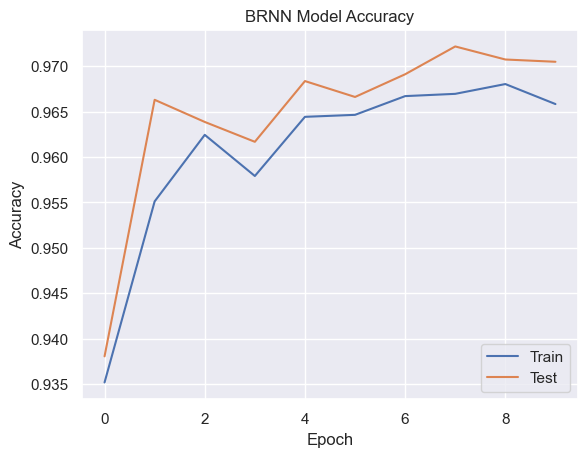

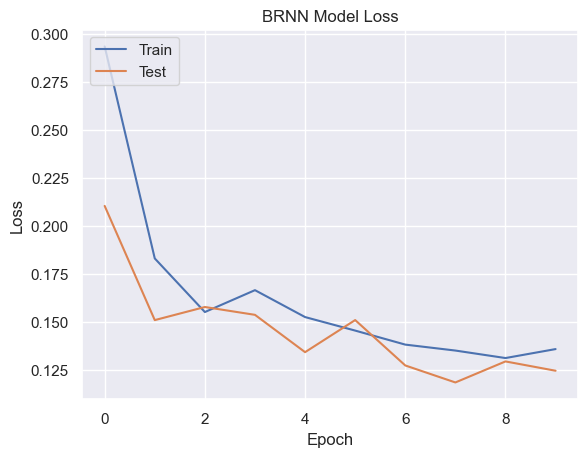

In [87]:
model = getModel(model_name)

625/625 [==============================] - 5s 6ms/step
accuracy: 96.91%


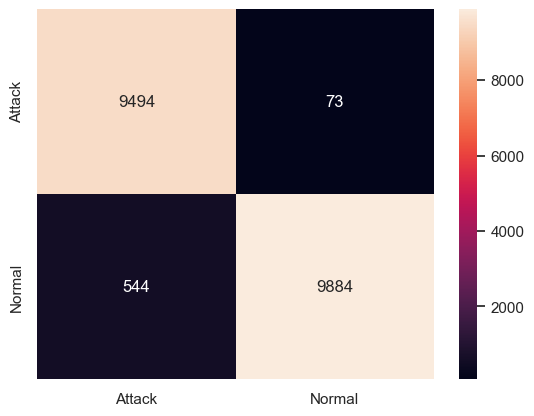

In [89]:
evaluateModel(model_name,model,X_test,Y_test,"test")

<center><h1>Test on live data</h1></center>
<p>Live packet is captured with the help of <b>Wireshark</b> and <b>Pyshark</b></p>
<p>Packets are captured using <a href="./capturePacket.py">capturePacket.py</a> </p>
<p>The captured packets are stored in <a href="./packets.pcap">packets.pcap</a> </p>
<p>The pcap file is processed and required attributes are collected from the packet data using the <a href="./processPackets.py">processPackets.py</a> and is stored in <a href="./packets.csv">packets.csv</a></p>

In [90]:
live_data = pd.read_csv('packets.csv')
X_live, Y_live = preProcess(live_data,[])

In [91]:
print(X_live.shape, Y_live.shape)
X_live = np.asarray(X_live).astype(np.float32)
Y_live = np.asarray(Y_live).astype(np.float32)

(53, 25, 25) (78,)


2/2 [==============================] - 0s 8ms/step
accuracy: 56.60%


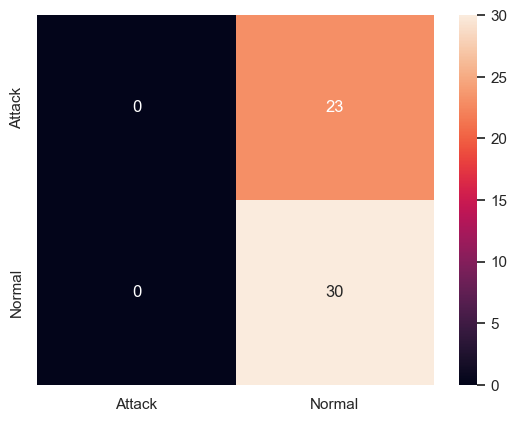

In [92]:
evaluateModel(model_name,model,X_live,Y_live[:X_live.shape[0]],'live')